# IRWS Homework 03
*Sebastian Wagner*
## Exercise 1
### a)

In [35]:
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np
import nltk
import string
import math
import sklearn.cluster

from nltk.tokenize import TreebankWordTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

defining the documents here and set the vocabulary

In [4]:
TOKENIZER = TreebankWordTokenizer()
LEMMATIZER = WordNetLemmatizer()


d1 = "Frodo and Sam were trembling in the darkness, surrounded in darkness by hundreds of blood-thirsty orc. Sam was certain these beasts were about to taste the scent of their flesh."
d2 = "The faceless black beast then stabbed Frodo. He felt like every nerve in his body was hurting. Suddenly, he thought of Sam and his calming smile. Frodo had betrayed him."
d3 = "Frodo’s sword was radiating blue, stronger and stronger every second. Orc were getting closer. And these weren’t just regular orc either, Uruk-Hai were among them. Frodo had killed regular orc before, but he had never stabbed an Uruk-Hai, not with the blue stick."
d4 = "Sam was carrying a small lamp, shedding some blue light. He was afraid that orc might spot him, but it was the only way to avoid deadly pitfalls of Mordor."

docs = [d1.lower(), d2.lower(), d3.lower(), d4.lower()]


ORDERED_VOC = [t.lower() for t in ["Frodo", "Sam", "beast", "orc", "blue"]]
VOC = set(ORDERED_VOC)

defining some functions here that will be needed later on

In [5]:
# stolen from http://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def reduce_to_voc(tokens):
    t_rel = []
    for t in tokens:
        if t in VOC:
            t_rel.append(t)
    return t_rel

def lemmatize(tokens):
    tagged = nltk.pos_tag(tokens)
    for t in tagged:
        try:
            yield LEMMATIZER.lemmatize(t[0], get_wordnet_pos(t[1]))
        except KeyError:
            pass
        
def tokenize(doc):
    doc = " ".join("".join([" " if ch in string.punctuation else ch for ch in doc]).split())
    result = []
    for token in TOKENIZER.tokenize(doc):
        result.append(token.lower())
    return result

def preprocess(doc):
    tokens = tokenize(doc)
    tokens = lemmatize(tokens)
    tokens = reduce_to_voc(tokens)
    return tokens

do preprocessing, the follwoing tokens remain
documents are numbered horizontally, commencing from doc1

In [6]:
docs_prep = []
for doc in docs:
    docs_prep.append(preprocess(doc))
pprint(docs_prep)

[['frodo', 'sam', 'orc', 'sam', 'beast'],
 ['beast', 'frodo', 'sam', 'frodo'],
 ['blue', 'orc', 'orc', 'frodo', 'orc', 'blue'],
 ['sam', 'blue', 'orc']]


compute the idf matrix

In [7]:
def compute_idf(docs):
    mat = np.zeros((len(ORDERED_VOC), len(ORDERED_VOC)))
    no_docs = len(docs)
    for doc in docs:
        for i in range(len(ORDERED_VOC)):
            term = ORDERED_VOC[i]
            mat[i,i] += 1 if term in doc else 0
    return np.divide(mat, no_docs)

idf = compute_idf(docs_prep)
pprint(ORDERED_VOC)
pprint(idf)

['frodo', 'sam', 'beast', 'orc', 'blue']
array([[ 0.75,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.75,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.5 ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.75,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.5 ]])


compute the tf matrix

In [8]:
def compute_tf(docs):
    mat = np.zeros((len(docs) ,len(ORDERED_VOC)))
    for d in range(len(docs)):
        doc = docs[d]
        for t in range(len(ORDERED_VOC)):
            term = ORDERED_VOC[t]
            mat[d][t] = doc.count(term)
    return mat

tf = compute_tf(docs_prep)
pprint(tf)

array([[ 1.,  2.,  1.,  1.,  0.],
       [ 2.,  1.,  1.,  0.,  0.],
       [ 1.,  0.,  0.,  3.,  2.],
       [ 0.,  1.,  0.,  1.,  1.]])


compute the tf-idf matrix, then transpose it so it is in document-term format

In [9]:
tf_idf = np.matmul(tf, idf)
term_doc_tfidf = np.transpose(tf_idf)
pprint(term_doc_tfidf)

array([[ 0.75,  1.5 ,  0.75,  0.  ],
       [ 1.5 ,  0.75,  0.  ,  0.75],
       [ 0.5 ,  0.5 ,  0.  ,  0.  ],
       [ 0.75,  0.  ,  2.25,  0.75],
       [ 0.  ,  0.  ,  1.  ,  0.5 ]])


### b)

In [10]:
def svd(mat):
    return np.linalg.svd(mat)
    
u, sigma, v = svd(term_doc_tfidf)
sigma = np.diag(sigma)
    
pprint([u, sigma, v])

[array([[-0.46176305, -0.4352475 , -0.73434277,  0.08708796, -0.22470177],
       [-0.40142314, -0.5883274 ,  0.66623669,  0.16253806, -0.14980118],
       [-0.13572251, -0.28374531, -0.05707485, -0.29992719,  0.89880706],
       [-0.72507269,  0.52902442,  0.11562721, -0.41883529, -0.07490059],
       [-0.28545288,  0.3225713 , -0.01556212,  0.83702912,  0.33705265]]),
 array([[ 3.10777963,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.96446704,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.04054244,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.29554427]]),
 array([[-0.50200559, -0.34158573, -0.72823333, -0.31778261],
       [-0.48564371, -0.62917291,  0.60395038,  0.05946061],
       [ 0.48703533, -0.60581294, -0.29422921,  0.55607233],
       [-0.5243445 ,  0.34706097, -0.13545965,  0.76567762]])]


### c)

Latent matrices with K2
[array([[-0.46176305, -0.4352475 ],
       [-0.40142314, -0.5883274 ],
       [-0.13572251, -0.28374531],
       [-0.72507269,  0.52902442],
       [-0.28545288,  0.3225713 ]]),
 array([[ 3.10777963,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.96446704,  0.        ,  0.        ]]),
 array([[-0.50200559, -0.34158573],
       [-0.48564371, -0.62917291],
       [ 0.48703533, -0.60581294],
       [-0.5243445 ,  0.34706097]])]

doc vector in 2 dimensional space
array([[-1.56012276, -1.50927363,  1.51359849, -1.62954716],
       [-0.67103391, -1.23598945, -1.19009955,  0.68178984]])


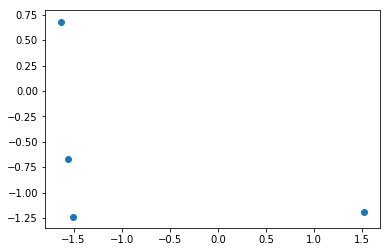

In [11]:
sigma_2 = sigma[:2,:]
u_2 = u[:,:2]
v_2 = v[:,:2]
print('Latent matrices with K2')
pprint([u_2, sigma_2, v_2])

dense_vec = np.matmul(sigma_2, np.transpose(v))

print('\ndoc vector in 2 dimensional space')
pprint(dense_vec)

x = dense_vec[:1,:]
y = dense_vec[1:2,:]

plt.scatter(x, y)
plt.show()

### d)


In [12]:
query= ['sam', 'blue', 'orc']
tf_query = compute_tf([query])
tf_idf_query = np.transpose(np.matmul(tf_query, idf))
print('TF-IDF vector query')
pprint([tf_idf_query])

print('\nQuery Vector in latent space ')
dense_query = np.matmul(np.transpose(u_2), tf_idf_query)
pprint(dense_query)

def cosine(doc1, doc2):
    length_doc1 = 0
    length_doc2 = 0
    scalar = 0.0
    if not len(doc1) == len(doc2):
        raise ValueError('Vectors of different length')
    for i in range(len(doc1)):
        scalar += doc1[i] * doc2[i]
        length_doc1 += math.pow(doc1[i], 2) 
        length_doc2 += math.pow(doc2[i], 2)
    length_doc1, length_doc2 = math.sqrt(length_doc1), math.sqrt(length_doc2)
    return scalar / (length_doc1 + length_doc2)

def rank(doc_term, query_term):
    ranking = []
    i = 0
    for doc in (doc_term):
        sim = {'doc':  doc,
               'index' : i+1,
               'similarity' : cosine(doc, query_term)
              }
        i += 1
        ranking.append(sim)
    return sorted(ranking, key=lambda x: x['similarity'], reverse=True)


    
ranked = rank(np.transpose(dense_vec), np.transpose(dense_query)[0])
print('\nranked documents:')
pprint(ranked)


TF-IDF vector query
[array([[ 0.  ],
       [ 0.75],
       [ 0.  ],
       [ 0.75],
       [ 0.5 ]])]

Query Vector in latent space 
array([[-0.98759831],
       [ 0.11680842]])

ranked documents:
[{'doc': array([-1.62954716,  0.68178984]),
  'index': 4,
  'similarity': 0.61174681110603102},
 {'doc': array([-1.56012276, -0.67103391]),
  'index': 1,
  'similarity': 0.54307578097291054},
 {'doc': array([-1.50927363, -1.23598945]),
  'index': 2,
  'similarity': 0.45706564310875086},
 {'doc': array([ 1.51359849, -1.19009955]),
  'index': 3,
  'similarity': -0.55954959440477048}]


## Exercise 2
### a)

In [28]:
doc_term_idfvector = [
    [0.17, 0.21, 0.35, 0.44, 0.49, 0.39, 0.09, 0.07, 0.37, 0.24],
    [0.49, 0.48, 0.44, 0.09, 0.24, 0.2, 0.41, 0.16, 0.1, 0.15],
    [0.41, 0.36, 0.27, 0.19, 0.15, 0.42, 0.23, 0.42, 0.02, 0.42],
    [0.31, 0.41, 0.21, 0.19, 0.47, 0.28, 0.21, 0.39, 0.16, 0.38],
    [0.46, 0.12, 0.21, 0.25, 0.38, 0.38, 0.46, 0.23, 0.31, 0.14],
    [0.13, 0.33, 0.28, 0.42, 0.07, 0.13, 0.58, 0.15, 0.0, 0.49],
    [0.21, 0.09, 0.07, 0.09, 0.3, 0.54, 0.24, 0.43, 0.51, 0.21],
    [0.18, 0.39, 0.42, 0.05, 0.41, 0.1, 0.52, 0.12, 0.14, 0.38],
    [0.4, 0.51, 0.01, 0.1, 0.12, 0.22, 0.26, 0.34, 0.42, 0.38]
]


def avg_cluster_similarity(cluster, doc):
    similarity = 0.0
    for member in cluster:
        similarity += cosine(member, doc)
    sim = similarity/len(cluster)
    return sim

def max_cluster_similarity(cluster, doc):
    max_similarity = 0.0
    for member in cluster:
        current_sim = cosine(member, doc)
        if current_sim > max_similarity:
            max_similarity = current_sim
    return max_similarity
    
def single_pass_clustering(docs, lamda, cluster_similarity):
    """
    returns: clusters; first array is the list of clusters, which then contains a list of documents
    """
    clusters = []
    clusters.append([docs.pop(-1)])
    # loop over each doc and try to assign to cluster
    for doc in docs:
        max_similarity = 0
        best_cluster = None
        for cluster in clusters:
            # determine the best matching cluster, lamda will be checked later on
            sim = cluster_similarity(cluster, doc)
            if sim > max_similarity:
                max_similarity = sim
                best_cluster = cluster
        if lamda > max_similarity:
            # create a new cluster
            clusters.append([doc])
        else:
            # append to existing cluster
            best_cluster.append(doc)
    return clusters


def print_clusters(clusters):
    i = 0
    for cluster in clusters:
        print('Cluster %s:' % (str(i)))
        i += 1
        print('\t' + "; ".join([str(doc) for doc in cluster]))
    
spc0_6 = single_pass_clustering(doc_term_idfvector, 0.6, max_cluster_similarity)
spc0_8 = single_pass_clustering(doc_term_idfvector, 0.8, max_cluster_similarity)

print('Single pass clustering with lamda=0.6')
print_clusters(spc0_6)

print('Single pass clustering with lamda=0.8')
print_clusters(spc0_8)

Single pass clustering with lamda=0.6
Cluster 0:
	[0.4, 0.51, 0.01, 0.1, 0.12, 0.22, 0.26, 0.34, 0.42, 0.38]
Cluster 1:
	[0.17, 0.21, 0.35, 0.44, 0.49, 0.39, 0.09, 0.07, 0.37, 0.24]
Cluster 2:
	[0.49, 0.48, 0.44, 0.09, 0.24, 0.2, 0.41, 0.16, 0.1, 0.15]
Cluster 3:
	[0.41, 0.36, 0.27, 0.19, 0.15, 0.42, 0.23, 0.42, 0.02, 0.42]
Cluster 4:
	[0.31, 0.41, 0.21, 0.19, 0.47, 0.28, 0.21, 0.39, 0.16, 0.38]
Cluster 5:
	[0.46, 0.12, 0.21, 0.25, 0.38, 0.38, 0.46, 0.23, 0.31, 0.14]
Cluster 6:
	[0.13, 0.33, 0.28, 0.42, 0.07, 0.13, 0.58, 0.15, 0.0, 0.49]
Cluster 7:
	[0.21, 0.09, 0.07, 0.09, 0.3, 0.54, 0.24, 0.43, 0.51, 0.21]
Cluster 8:
	[0.18, 0.39, 0.42, 0.05, 0.41, 0.1, 0.52, 0.12, 0.14, 0.38]
Single pass clustering with lamda=0.8
Cluster 0:
	[0.18, 0.39, 0.42, 0.05, 0.41, 0.1, 0.52, 0.12, 0.14, 0.38]
Cluster 1:
	[0.17, 0.21, 0.35, 0.44, 0.49, 0.39, 0.09, 0.07, 0.37, 0.24]
Cluster 2:
	[0.49, 0.48, 0.44, 0.09, 0.24, 0.2, 0.41, 0.16, 0.1, 0.15]
Cluster 3:
	[0.41, 0.36, 0.27, 0.19, 0.15, 0.42, 0.23, 0.4

I tried average cluster similarity and maximum cluster similarity, however, the similarities within the cluster are mostly in a range between .2 and .45. The change of lamda therefore stays mostly without effect.
In generall a lower lamda will lead to less clusters as the algorithm will assign a document with lower similarities to an existing cluster

In [31]:
spc0_8_reversed = single_pass_clustering([d for d in reversed(doc_term_idfvector)], 0.8, max_cluster_similarity)
print('Single pass clustering with lamda=0.8 and reversed streamlining')
print_clusters(spc0_8_reversed)

Single pass clustering with lamda=0.8 and reversed streamlining
Cluster 0:
	[0.17, 0.21, 0.35, 0.44, 0.49, 0.39, 0.09, 0.07, 0.37, 0.24]
Cluster 1:
	[0.21, 0.09, 0.07, 0.09, 0.3, 0.54, 0.24, 0.43, 0.51, 0.21]
Cluster 2:
	[0.13, 0.33, 0.28, 0.42, 0.07, 0.13, 0.58, 0.15, 0.0, 0.49]
Cluster 3:
	[0.46, 0.12, 0.21, 0.25, 0.38, 0.38, 0.46, 0.23, 0.31, 0.14]
Cluster 4:
	[0.31, 0.41, 0.21, 0.19, 0.47, 0.28, 0.21, 0.39, 0.16, 0.38]
Cluster 5:
	[0.41, 0.36, 0.27, 0.19, 0.15, 0.42, 0.23, 0.42, 0.02, 0.42]
Cluster 6:
	[0.49, 0.48, 0.44, 0.09, 0.24, 0.2, 0.41, 0.16, 0.1, 0.15]


The clusters change, which is entailed by the different start cluster the algorithm has chosen

### b)

In [60]:
centroids = [
    [0.33, 0.33, 0.42, 0.12, 0.2, 0.34, 0.58, 0.19, 0.07, 0.24],
    [0.29, 0.16, 0.38, 0.48, 0.43, 0.11, 0.12, 0.33, 0.03, 0.44],
    [0.01, 0.17, 0.11, 0.27, 0.23, 0.37, 0.35, 0.48, 0.54, 0.24]
]
centroids_np = np.array(centroids)

kmeans = sklearn.cluster.KMeans(n_clusters=3, init=centroids_np).fit(np.array(doc_term_idfvector))
centers = kmeans.cluster_centers_

print('Cluster centers')
pprint(centers)

for doc in doc_term_idfvector:
    clusters = []
    best_cluster = None
    max_sim = 0.0
    for center in range(len(centers)):
        sim = avg_cluster_similarity([centers[center]], doc)
        if max_sim < sim:
            max_sim = sim
            best_cluster = center
    print('Doc %s assigned to cluster %s' %(doc, str(best_cluster)))
        
    



        
    

Cluster centers
array([[ 0.3725,  0.3225,  0.3   ,  0.2375,  0.21  ,  0.2825,  0.42  ,
         0.24  ,  0.1075,  0.3   ],
       [ 0.24  ,  0.31  ,  0.28  ,  0.315 ,  0.48  ,  0.335 ,  0.15  ,
         0.23  ,  0.265 ,  0.31  ],
       [ 0.21  ,  0.09  ,  0.07  ,  0.09  ,  0.3   ,  0.54  ,  0.24  ,
         0.43  ,  0.51  ,  0.21  ]])
Doc [0.17, 0.21, 0.35, 0.44, 0.49, 0.39, 0.09, 0.07, 0.37, 0.24] assigned to cluster 1
Doc [0.49, 0.48, 0.44, 0.09, 0.24, 0.2, 0.41, 0.16, 0.1, 0.15] assigned to cluster 0
Doc [0.41, 0.36, 0.27, 0.19, 0.15, 0.42, 0.23, 0.42, 0.02, 0.42] assigned to cluster 0
Doc [0.31, 0.41, 0.21, 0.19, 0.47, 0.28, 0.21, 0.39, 0.16, 0.38] assigned to cluster 1
Doc [0.46, 0.12, 0.21, 0.25, 0.38, 0.38, 0.46, 0.23, 0.31, 0.14] assigned to cluster 0
Doc [0.13, 0.33, 0.28, 0.42, 0.07, 0.13, 0.58, 0.15, 0.0, 0.49] assigned to cluster 0
Doc [0.21, 0.09, 0.07, 0.09, 0.3, 0.54, 0.24, 0.43, 0.51, 0.21] assigned to cluster 2


/usr/local/lib/python3.5/dist-packages/sklearn/cluster/k_means_.py:889: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


## Exercise 3
### a)